<a href="https://colab.research.google.com/github/anishkanabar/lang-of-pol/blob/master/Inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Introduction
In this notebook, we will train a generative adversarial network (GAN) to perform the task of image inpainting. A GAN consists of a generator, which learns to generate plausible data, and a discriminator, which learns to distinguish the generator's fake data from real data.

Futhermore, the generator employed here is comprised of an encoder for downsampling to a latent feature representation and a decoder for upsampling to a novel image. The weights from the generator will be saved and transferred to a classifier (classification.ipynb) that builds on the encoder part of the generator.

The model architecture is inspired by "Context Encoders: Feature Learning by Inpainting" (Pathak et al, 2016). The authors were successful in performing inpainting on several benchmark datasets and extended their model to perform classification as well as segmentation and object detection.

Mount Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the necessary libraries.

In [ ]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

Define some constants for image preprocessing and model training.

In [ ]:
# Number of epochs of training
N_EPOCHS = 15
# Size of the batches
BATCH_SIZE = 16
# Name of the dataset
DATASET_NAME = '/content/drive/MyDrive/OSAIL_Data/Unlabeled'
# adam: learning rate
LR = 0.00008
# adam: decay of first order momentum of gradient
B1 = 0.5
# adam: decay of first order momentum of gradient
B2 = 0.999
# Number of cpu threads to use during batch generation
N_CPU = 4
# Dimensionality of the latent space
LATENT_DIM = 100
# Size of each image dimension
IMG_SIZE = 128
# Size of random mask
MASK_SIZE = 64
# Number of image channels
CHANNELS = 1
# Interval between image sampling
SAMPLE_INTERVAL = 500

cuda = True if torch.cuda.is_available() else False
os.makedirs("images", exist_ok=True)

# Calculate the output dimensions of the image discriminator
patch_h, patch_w = int(MASK_SIZE / 2 ** 3), int(MASK_SIZE / 2 ** 3)
patch = (1, patch_h, patch_w)

Define a class for image loading and preprocessing. Random masking will be used during training in order to generate more training samples while center masking will be used during testing to standardize evaluation.

In [ ]:
class ImageDataset(Dataset):
    """Custom implementation of the PyTorchDataset class for image loading and preprocessing"""
    def __init__(self, root, transforms_=None, img_size=128, mask_size=64, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.img_size = img_size
        self.mask_size = mask_size
        self.mode = mode
        self.files = sorted(glob.glob("%s/*.png" % root))

    def apply_random_mask(self, img):
        """Randomly masks the image"""
        y1, x1 = np.random.randint(0, self.img_size - self.mask_size, 2)
        y2, x2 = y1 + self.mask_size, x1 + self.mask_size
        masked_part = img[:, y1:y2, x1:x2]
        masked_img = img.clone()
        masked_img[:, y1:y2, x1:x2] = 1

        return masked_img, masked_part

    def apply_center_mask(self, img):
        """Masks the center of the image"""
        i = (self.img_size - self.mask_size) // 2
        masked_img = img.clone()
        masked_img[:, i : i + self.mask_size, i : i + self.mask_size] = 1

        return masked_img, i

    def __getitem__(self, index):
        """Returns the image, the masked image, and the masked part"""
        img = Image.open(self.files[index % len(self.files)])
        img = self.transform(img)
        if self.mode == "train":
            # For training, perform a random mask
            masked_img, aux = self.apply_random_mask(img)
        else:
            # For testing, mask the center of the image
            masked_img, aux = self.apply_center_mask(img)

        return img, masked_img, aux

    def __len__(self):
        return len(self.files)

Standardize the images using torch.transforms and initialize PyTorch DataLoaders.

In [ ]:
transforms_ = [
    transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
]
train_dataloader = DataLoader(
    ImageDataset(DATASET_NAME, transforms_=transforms_),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=N_CPU,
)
test_dataloader = DataLoader(
    ImageDataset(DATASET_NAME, transforms_=transforms_, mode="val"),
    batch_size=12,
    shuffle=True,
    num_workers=1,
)

Here is an example of random masking:

<Figure size 800x800 with 0 Axes>

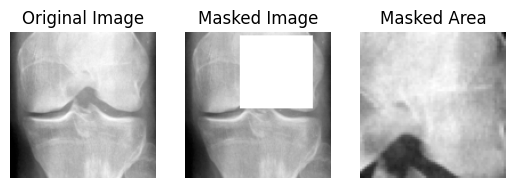

In [ ]:
imgs, masked_imgs, masked_parts = next(iter(train_dataloader))
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 1
f, axarr = plt.subplots(1,3)

axarr[0].imshow(imgs[0].squeeze(), cmap='gray',)
axarr[0].set_title('Original Image')
axarr[0].axis('off')
axarr[1].imshow(masked_imgs[0].squeeze(), cmap='gray',)
axarr[1].set_title('Masked Image')
axarr[1].axis('off')
axarr[2].imshow(masked_parts[0].squeeze(), cmap='gray',)
axarr[2].set_title('Masked Area')
axarr[2].axis('off');

Define the generator, which consists of an encoder with 5 downsampling (convolutional) layers and a decoder with 4 upsampling (transposed convolutional) layers.

In [ ]:
class Generator(nn.Module):
    """The generator module of the generative adversarial network"""
    def __init__(self, channels=3):
        super(Generator, self).__init__()

        def downsample(in_feat, out_feat, normalize=True):
            """Each downsample layer consists of convolution, batch normalization, and activation"""
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        def upsample(in_feat, out_feat, normalize=True):
            """Each upsample layer consists of transposed convolution, batch normalization, and activation"""
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.ReLU())
            return layers

        self.model = nn.Sequential(
            # Encoder block
            *downsample(channels, 64, normalize=False),
            *downsample(64, 64),
            *downsample(64, 128),
            *downsample(128, 256),
            *downsample(256, 512),

            nn.Conv2d(512, 4000, 1),

            # Decoder block
            *upsample(4000, 512),
            *upsample(512, 256),
            *upsample(256, 128),
            *upsample(128, 64),
            nn.Conv2d(64, channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        output = self.model(x)
        return output

Define the discriminator, which consists of 4 convolutional layers.

In [ ]:
class Discriminator(nn.Module):
    """The discriminator module of the generative adversarial network"""
    def __init__(self, channels=3, num_labels=5):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, stride, normalize):
            """Returns layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = channels
        for out_filters, stride, normalize in [(64, 2, False), (128, 2, True), (256, 2, True), (512, 1, True)]:
            layers.extend(discriminator_block(in_filters, out_filters, stride, normalize))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, 3, 1, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        output = self.model(img)
        return output

Prepare the generator and discriminator for training.

In [ ]:
def weights_init_normal(m):
    """Initialize the model weights as normally distributed and bias as constant"""
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

def save_sample(batches_done):
    """Save each batch of inpainted images"""
    samples, masked_samples, i = next(iter(test_dataloader))
    samples = samples.type(Tensor)
    masked_samples = masked_samples.type(Tensor)
    i = i[0].item()
    # Generate an inpainted image
    gen_mask = generator(masked_samples)
    filled_samples = masked_samples.clone()
    filled_samples[:, :, i : i + MASK_SIZE, i : i + MASK_SIZE] = gen_mask
    # Save a sample
    sample = torch.cat((masked_samples.data, filled_samples.data, samples.data), -2)
    save_image(sample, "images/%d.png" % batches_done, nrow=6, normalize=True)

# Loss functions: Mean Square Error and L1
adversarial_loss = torch.nn.MSELoss()
pixelwise_loss = torch.nn.L1Loss()

# Initialize the generator and discriminator
generator = Generator(channels=CHANNELS)
discriminator = Discriminator(channels=CHANNELS)

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    pixelwise_loss.cuda()

# Initialize model weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Use the adam optimizer for both the generator and discriminator
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=(B1, B2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(B1, B2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Train the generator and discriminator in alternating fashion.

In [ ]:
%%time

gen_adv_losses, gen_pixel_losses, disc_losses, counter = [], [], [], []

for epoch in range(N_EPOCHS):
    # Training loop:
    gen_adv_loss, gen_pixel_loss, disc_loss = 0, 0, 0
    tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=int(len(train_dataloader)))
    for i, (imgs, masked_imgs, masked_parts) in enumerate(tqdm_bar):

        # Adversarial ground truths
        valid = Tensor(imgs.shape[0], *patch).fill_(1.0)
        fake = Tensor(imgs.shape[0], *patch).fill_(0.0)

        # Configure the input
        imgs = imgs.type(Tensor)
        masked_imgs = masked_imgs.type(Tensor)
        masked_parts = masked_parts.type(Tensor)

        # Train the generator:
        optimizer_G.zero_grad()

        # Generate a batch of images
        gen_parts = generator(masked_imgs)

        # Adversarial and pixelwise loss
        g_adv = adversarial_loss(discriminator(gen_parts), valid)
        g_pixel = pixelwise_loss(gen_parts, masked_parts)
        # Total loss
        g_loss = 0.001 * g_adv + 0.999 * g_pixel

        g_loss.backward()
        optimizer_G.step()

        # Train the discriminator:
        optimizer_D.zero_grad()

        # Measure the discriminator's ability to distinguish real from generated samples
        real_loss = adversarial_loss(discriminator(masked_parts), valid)
        fake_loss = adversarial_loss(discriminator(gen_parts.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

        gen_adv_loss, gen_pixel_loss, disc_loss
        gen_adv_losses, gen_pixel_losses, disc_losses, counter

        gen_adv_loss += g_adv.item()
        gen_pixel_loss += g_pixel.item()
        gen_adv_losses.append(g_adv.item())
        gen_pixel_losses.append(g_pixel.item())
        disc_loss += d_loss.item()
        disc_losses.append(d_loss.item())
        counter.append(i*BATCH_SIZE + imgs.size(0) + epoch*len(train_dataloader.dataset))
        tqdm_bar.set_postfix(gen_adv_loss=gen_adv_loss/(i+1), gen_pixel_loss=gen_pixel_loss/(i+1), disc_loss=disc_loss/(i+1))

        # Generate a sample at the sample interval
        batches_done = epoch * len(train_dataloader) + i
        if batches_done % SAMPLE_INTERVAL == 0:
            save_sample(batches_done)

    torch.save(generator.state_dict(), "/content/drive/MyDrive/generator.pth")

Training Epoch 0 :   0%|          | 0/465 [00:00<?, ?it/s]

Training Epoch 1 :   0%|          | 0/465 [00:00<?, ?it/s]

Training Epoch 2 :   0%|          | 0/465 [00:00<?, ?it/s]

Training Epoch 3 :   0%|          | 0/465 [00:00<?, ?it/s]

Training Epoch 4 :   0%|          | 0/465 [00:00<?, ?it/s]

Training Epoch 5 :   0%|          | 0/465 [00:00<?, ?it/s]

Training Epoch 6 :   0%|          | 0/465 [00:00<?, ?it/s]

Training Epoch 7 :   0%|          | 0/465 [00:00<?, ?it/s]

Training Epoch 8 :   0%|          | 0/465 [00:00<?, ?it/s]

Training Epoch 9 :   0%|          | 0/465 [00:00<?, ?it/s]

Training Epoch 10 :   0%|          | 0/465 [00:00<?, ?it/s]

Training Epoch 11 :   0%|          | 0/465 [00:00<?, ?it/s]

Training Epoch 12 :   0%|          | 0/465 [00:00<?, ?it/s]

Training Epoch 13 :   0%|          | 0/465 [00:00<?, ?it/s]

Training Epoch 14 :   0%|          | 0/465 [00:00<?, ?it/s]

CPU times: user 7min 24s, sys: 22.3 s, total: 7min 46s
Wall time: 12min 39s


Display the results.

Final Epoch MSE Loss 0.964
Final Epoch L1 Loss 0.086


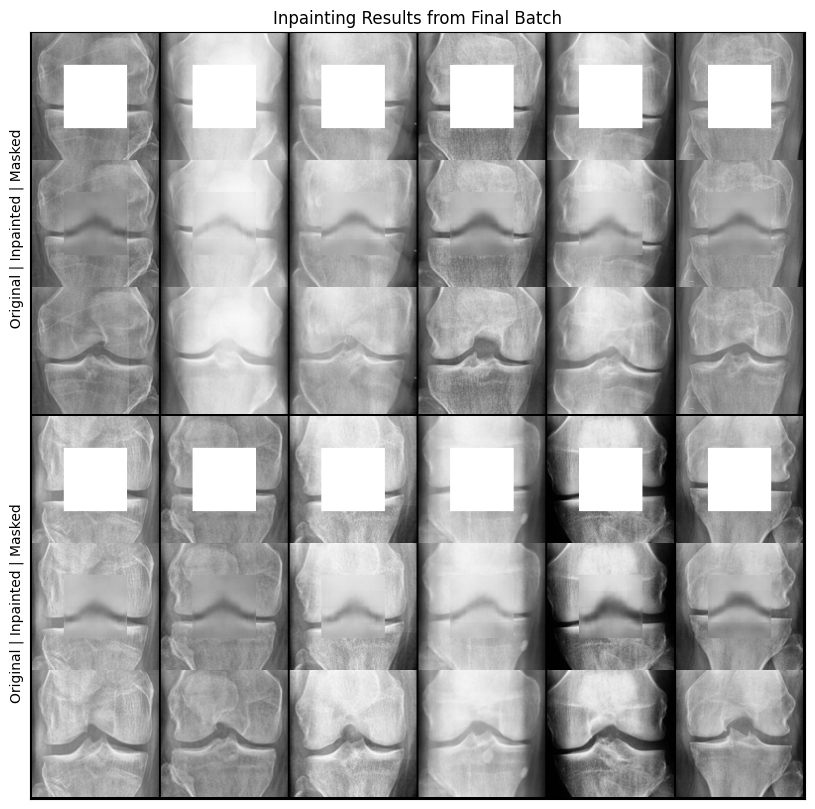

In [ ]:
print("Final Epoch MSE Loss " + str(g_adv.item())[:5])
print("Final Epoch L1 Loss " + str(g_pixel.item())[:5])

plt.figure(figsize=(10,10))
img = Image.open('images/6500.png')
imgplot = plt.imshow(img)
plt.title('Inpainting Results from Final Batch')
label = 'Original | Inpainted | Masked' + ' '*40  + 'Original | Inpainted | Masked'
plt.ylabel(label)
plt.yticks([])
plt.xticks([])
plt.show()

###Conclusion

The above image, which represents the final batch from the final training epoch, demonstrates that the model performs reasonably well in inpainting. Various metrics are used for evaluating inpainting accuracy - and all are dataset dependent - but it is worth noting that the final L1 loss of 0.086 is comparable to the L1 loss obtained by Pathak et al (0.0937) for the Paris StreetView dataset.